<img src='../images/cbslogo.jpg' width="30%" align="left" />

# Vorhersage der Anzahl an Fahrradvorgängen pro Stunde (one hot encoding) mithilfe von Entscheidungsbäumen

## - Phase: Data Modelling -

Da unser Datensatz mit vielen unterschiedlichen Kategorien ausgestattet ist, scheint er zu Beginn sehr schlecht überschaubar zu sein. Daher war das Ziel, mithilfe eines Entscheidungsbaums eine Klassifizierung durchzuführen. 

Dieses Notebook nutzt die folgenden Dateien:
    training.pkl,
    test.pkl.



Zu Beginn installieren wir das Python Package XGBoost: https://xgboost.readthedocs.io/en/latest/build.html
#conda install -c anaconda py-xgboost

In [26]:
# Bibliotheken laden:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBClassifier
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')



In [3]:
DATA_PATH = '../data/'

Wir lesen eine für das weitere Data Mining vorbereitete Pickle-Datei ein. Hier haben wir Spalten mit fehlenden Werten bereits entfernt, nutzen numerische Kategorien und haben solche Kategorien mit geringer Kardinalität "one-hot-encoded".

In [4]:
df = pd.read_pickle(DATA_PATH+'counts_prepared.pkl')

In [6]:
df.head()
# Der Dataframe wurde bis auf "Date" bereits in numerische Werte umgewandelt. 

,date,count_in,count_out,day_of_week,dewpoint,humidity,precipitation,pressure,temperature,winddirection,...,hour_19,hour_20,hour_21,hour_22,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2015-01-01,42,54,1,-14.0,29.0,0.0,1026.7,2.2,220.0,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-01,98,114,1,-12.3,36.0,0.0,1026.5,1.1,210.0,...,0,0,0,0,0,0,0,1,0,0
2,2015-01-01,116,100,1,-11.0,40.0,0.0,1026.3,1.1,230.0,...,0,0,0,0,0,0,0,1,0,0
3,2015-01-01,27,16,1,-11.8,39.0,0.0,1025.6,0.6,250.0,...,0,0,0,0,0,0,0,1,0,0
4,2015-01-01,7,8,1,-11.2,41.0,0.0,1025.1,0.6,170.0,...,0,0,0,0,0,0,0,1,0,0


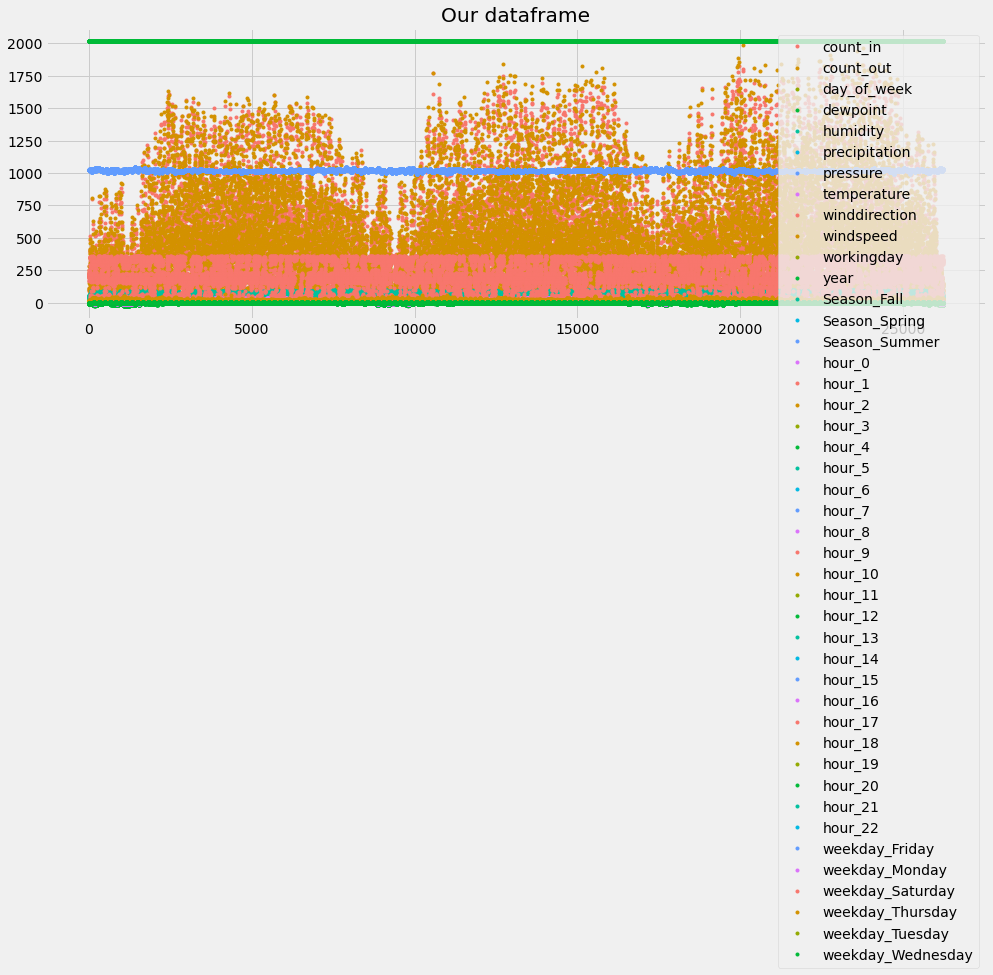

In [9]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal, title='Our dataframe')

Wir sehen, dass unser Datensatz viele unterschiedliche Kategorien beinhaltet. Ohne eine vorherige Einschränkung auf bestimmte Klassen der Daten oder das rückgängigmachende Aggregieren der Stunden/Wochentage zu Datumsangaben können wir anhand dieser Visualisierung nicht viel schlussfolgern. Generell gilt für das XGB auch, dass keine vorherige Normalisierung der Daten notwendig gewesen wäre.

Für das hier angewandte XGB-Verfahren ist dies allerdings nicht weiter bedenklich, da sich Entscheidungsbäume dank dem Prozess der rekursiven Partitionierung nur die zielführendsten binären Fragen für die Bildung von Entscheidungsbäumen nutzt. Das bedeutet, dass eventuale nicht-signifikanten Variablen die Ergebnisse nicht beeinflussen. Außerdem sind Entscheidungsbäume robust gegenüber Ausreißern.
Zudem brauchen wir diese differenzierten Zeit-Angaben (Wochentage und Uhrzeiten), da sie dem Aufbau des Entscheidungsbaumes als Kriterien für die Zweigbildung dienen.

Für eine bessere Übersicht über die unterschiedlichen Wetter-Kategorien unseres Data-Frames, visualisieren wir diese noch einmal separat:

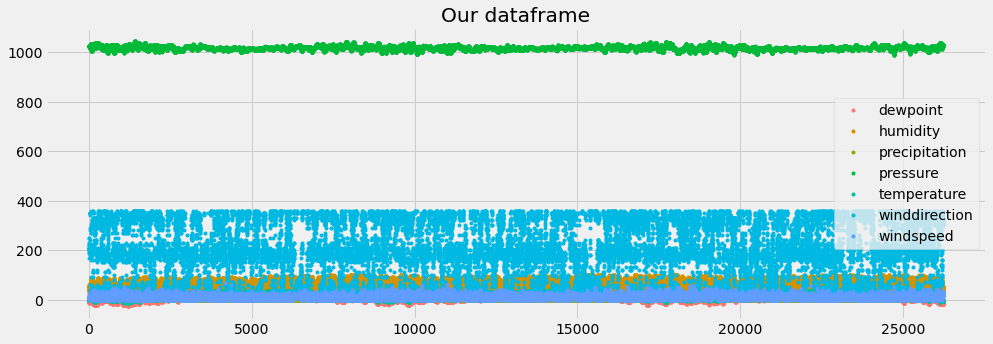

In [27]:
# Witterungsbedingungen:
df_weather = df.iloc[:,[4,5,6,7,8,9, 10]]
__ = df_weather.plot(style='.', figsize=(15,5), color=color_pal, title='Our dataframe')

### Trainings- und Testdaten (vgl. Notebook Nr. 70)

In [34]:
array = [2015, 2016]
dataTrain = df.loc[df['year'].isin(array)]
dataTrain = dataTrain.sort_values(by=['date'])
dataTest = df.loc[df['year']==2017]
dataTest = dataTest.sort_values(by=['date'])

datetimecol = dataTest['date']
yLabels = df["count_out"]

In [35]:
# Trennen von Trainings- und Testdaten in unabhängige Variablen (X) und abhängige Variable (count_out y)
drop_cols = ['date', 'count_in', 'index']
y_cols =['count_out']
feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

X_train = dataTrain[feature_cols]
X_test = dataTest[feature_cols]

y_train = dataTrain['count_out']
y_test = dataTest['count_out']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(17535, 42) (17535,) (8691, 42) (8691,)


In [36]:
X_train_def = dataTrain[feature_cols]
y_train_def =dataTrain['count_out']

Für eine bessere Performance des XGB-Algorithmus erstellen wir eine Datenmatrix aus den Trainigsdaten.

In [11]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)


## Erstellung eines Regressionsmodells:

In [39]:
# Modell für die Vorhersage anhand XGB:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', #Festlegung der Kostenfunktion für ein Regressionsproblem.
                          colsample_bytree = 0.3, #Prozentzahl der genutzten  Kategorien. Achtung: Hoher Wert kann zu Overfitting führen.
                          learning_rate = 0.1, #Schrittweite der Lernrate, um das Overfitting zu vermeiden - Wertebereich: [0,1]
                          max_depth = 5, #Bestimmt, wie tief ein Baum pro Boosting-Runde wachsen darf.
                          n_estimators = 10) #Anzahl der Bäume, die gebaut werden sollen.

# Funktion für das Trainieren des Modells:
xg_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,#Stoppe die Baumkonfiguration, wenn 50 nachfolgende Konfigurationsrunden zu keiner verbesserten Leistung (gemessen an der Fehlerrate) führen.
           verbose=False) #Trainiere den Algorithmus im Hintergrund. (Im Vordergrund mithilfe True.)  

# Ausgabe des Modells:
print(xg_reg)

# Training des Modells:
xg_reg.fit(X_train,y_train)

# Vorhersage;
preds = xg_reg.predict(X_test)

# Ausgabe der Metriken
rmsle = np.sqrt(mean_squared_log_error(y_test, preds))
print("RMSLE: %f" % (rmsle))
print(mean_squared_log_error(y_test, preds))

params = {'objective':'reg:squarederror','colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

# Durchführung einer Kreuzvalidierung:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

print((cv_results["test-rmse-mean"]).tail(1))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
RMSLE: 1.322928
1.7501390277402982
49    209.476517
Name: test-rmse-mean, dtype: float64


In [35]:
# Vorhersage anhand des Testdatensatzes:
y_pred = xg_reg.predict(X_test)
predictions1 = [round(value) for value in y_pred]
# Evaluiierung der Testvorhersage:
accuracy1 = accuracy_score(y_test, predictions1)
print("Accuracy: %.2f%%" % (accuracy1 * 100.0))

Accuracy: 0.07%


Dieses Modell hat eine Vorhersagegenauigkeit von 0,07 Prozent.

In [41]:
#R-Squared Wert berechnen:
print('R-Squared Value:', xg_reg.score(X_test, y_test))

R-Squared Value: 0.05623159872976813


In [13]:
# Test
xg_reg.fit(X_train,y_train)
im = pd.DataFrame({'importance':xg_reg.feature_importances_,'var':X_train.columns}) 
im=im.sort_values(by='importance',ascending=False)
im.head()


,importance,var
30,0.191287,hour_17
31,0.135658,hour_18
18,0.093147,hour_5
21,0.092033,hour_8
16,0.085522,hour_3


#### Visualisierung der Prognoseergebnisse:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

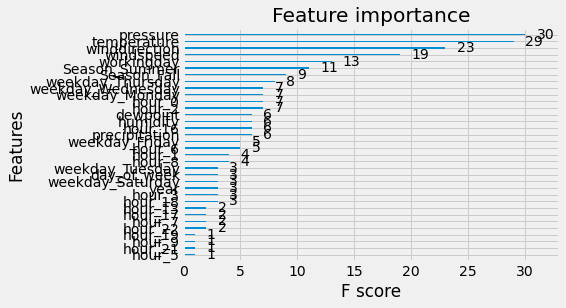

In [14]:
#Visualisierung von Feature Importance
xgb.plot_importance(xg_reg)

In [ ]:
# Visualisierung des Boosting-Tree:
plt.rcParams['figure.figsize'] = [50, 30]
xgb.plot_tree(xg_reg,num_trees=2)

### Erstellung eines Klassifikationsmodells

In [38]:
# Wir erstellen das Modell:
model = XGBClassifier(obective='binary:logistic') # Wir ändern diesen Parameter, da wir ein Klassifikationsmodell mit Ziel eine Wahrscheinlichkeitsfunktion betrachten.

# Trainiere das Modell:
model.fit(X_train, y_train)
print(model)



KeyboardInterrupt: 

In [17]:
# Vorhersage anhand des Testdatensatzes:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# Evaluiierung der Testvorhersage:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 1.10%


Die Vorhersagegenauigkeit dieses Modells beträgt 1,1 Prozent und schneidet somit besser ab als das Regressionsmodell.

In [ ]:
# Wir trainieren das Modell:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False)

In [19]:
# R-squared Wert
reg.score(X_test, y_test)
reg.score(X_train, y_train)

0.9428766935442954

In [20]:
reg.get_booster()

In [21]:
reg.feature_importances_

array([0.00101301, 0.00259485, 0.00196083, 0.00319289, 0.00116497,
       0.00773042, 0.00103584, 0.00110353, 0.00404717, 0.00113094,
       0.00425178, 0.00357922, 0.00533789, 0.05443285, 0.06742945,
       0.07400379, 0.07555632, 0.08171651, 0.0572797 , 0.02014963,
       0.01663245, 0.0642637 , 0.00676967, 0.00236774, 0.00750058,
       0.0161233 , 0.01490997, 0.01328779, 0.02311523, 0.06712823,
       0.11235134, 0.09262037, 0.03215346, 0.00792694, 0.00384861,
       0.0127255 , 0.00361763, 0.00376938, 0.01591618, 0.00474803,
       0.00482289, 0.00468948], dtype=float32)

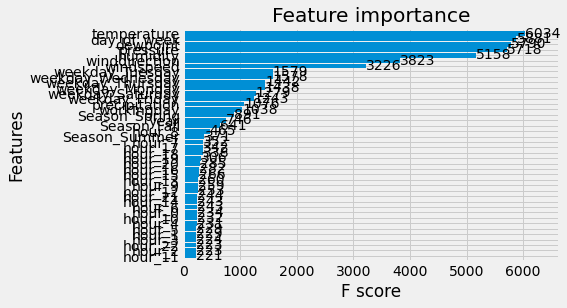

In [22]:
_ = plot_importance(reg, height=0.9)

#### Anmerkungen zum Hyperparameter-Tuning:
Ein großer Nachteil von Entscheidungsbäumen ist generell die Tendenz zum Overfitting. Beim Hyperparameter-Tuning muss also n_estimators und n_depth möglichst klein ausgewählt werden. Die Anwendung des XGB-Verfahrens hätte diesen Nachteil ausgleichen sollen.

**Fazit: Vorteil dies Modells ist zwar seine leichte und schnelle Verständlichkeit, da unser XGB-Modell leider sehr zeitintensiv ist, entscheiden wir uns im weiteren Verlauf gegen die Nutzung im Rahmen unseres Prognosemodells.** 

Tutorial-Quellen: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost und https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/
Literaturquellen: NgEtAl2018